In [1]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
import matplotlib
from dataclasses import replace
import time
from datetime import datetime
import pandas as pd
import nlopt

In [2]:
import sys
sys.path.append('/home/gridsan/wmichaels/xray_coherence')

from src.simparams import SimParams
from src.threshold_opt import threshold_opt
from src.forwardmodels import forward_model_focus_plane_wave, forward_model_focus_plane_wave_power, forward_model_focus_plane_wave_overlap
from src.elements import ArbitraryElement, ZonePlate
from src.propagation import propagate_z
from src.sources import plane_wave
from src.inversedesign_utils import heaviside_projection, zp_init
from src.forwardmodels import propagate_z_arbg_z, field_z_arbg_z
from src.util import kramers_law_weights, create_material_map, refractive_index_at_wvl, spherize_1d_array

In [3]:
matplotlib.rcParams['figure.dpi'] = 140
matplotlib.rcParams.update({'font.size': 15})

In [4]:
def colors_list(N):
    cmap = plt.colormaps['viridis']
    colors = [cmap(x) for x in np.linspace(0, 1, N)]
    
    return colors

In [5]:
ID = 'center_width_incoh2025-08-11 16.44.51'

In [6]:
path = 'home/gridsan/wmichaels/opt_out'
dicts = np.load(f'/{path}/{ID}_dict.npy', allow_pickle=True)
xs = np.load(f'/{path}/{ID}_xs.npz', allow_pickle=True)
xs_full = np.load(f'/{path}/{ID}_x_fulls.npz', allow_pickle=True)
Is = np.load(f'/{path}/{ID}_Is.npz', allow_pickle=True)
objs = np.load(f'/{path}/{ID}_objs.npz', allow_pickle=True)
objs = np.array([float(objs[key]) for key in objs.files])

In [7]:
dicts[0]["args"][1]

8

In [8]:
def print_dict_differences(list_of_dicts: list[dict]):
    """
    Compares a list of dictionaries and prints the paths to fields that differ.

    This function recursively traverses nested dictionaries and lists to find
    discrepancies in values between any of the dictionaries in the list.

    Args:
        list_of_dicts: A list containing two or more dictionaries to compare.
    """
    if not isinstance(list_of_dicts, list) or len(list_of_dicts) < 2:
        print("Input must be a list containing at least two dictionaries.")
        return

    # A unique object to represent a key or index that is missing in a dictionary/list.
    # This helps differentiate a missing key from a key with a value of None.
    _MISSING = object()

    def find_diffs_recursive(path: str, items: list):
        """
        Recursively compares a list of items (values from the same path in each dict).

        Args:
            path: The dot-separated path to the current field (e.g., "user.address.city").
            items: A list of values to compare at the given path.
        """
        # Determine the type of comparison needed based on the items
        is_all_dicts = all(isinstance(item, dict) for item in items)
        is_all_lists = all(isinstance(item, list) for item in items)

        if is_all_dicts:
            # --- Case 1: All items are dictionaries ---
            # Collect all unique keys present across all dictionaries at this level.
            all_keys = set()
            for d in items:
                # Ensure we don't call .keys() on a non-dict (like _MISSING)
                if isinstance(d, dict):
                    all_keys.update(d.keys())
            
            # Recursively check the values for each key.
            for key in sorted(list(all_keys)):
                new_path = f"{path}.{key}" if path else key
                values_for_key = [
                    d.get(key, _MISSING) if isinstance(d, dict) else _MISSING
                    for d in items
                ]
                find_diffs_recursive(new_path, values_for_key)

        elif is_all_lists:
            # --- Case 2: All items are lists ---
            # Find the length of the longest list to iterate through all possible indices.
            max_len = 0
            for lst in items:
                if isinstance(lst, list):
                    max_len = max(max_len, len(lst))
            
            # Recursively check the values at each index.
            for i in range(max_len):
                new_path = f"{path}[{i}]"
                values_at_index = [
                    lst[i] if isinstance(lst, list) and i < len(lst) else _MISSING
                    for lst in items
                ]
                find_diffs_recursive(new_path, values_at_index)

        else:
            # --- Case 3: Primitives, mixed types, or missing values ---
            # Use string representations to create a set of unique values.
            # This handles unhashable types like lists/dicts that might appear
            # in a mixed-type scenario.
            unique_values = {repr(v) for v in items}

            if len(unique_values) > 1:
                print(f"Difference found at: '{path}'")
                for i, value in enumerate(items):
                    if value is _MISSING:
                        print(f"  - Dict {i}: [FIELD MISSING]")
                    else:
                        # Use repr() to make the type clear (e.g., '1' vs 1)
                        print(f"  - Dict {i}: {repr(value)}")
                print("-" * 25)

    # Start the recursive comparison from the root level.
    find_diffs_recursive("", list_of_dicts)

In [9]:
print_dict_differences(list(dicts))

Difference found at: 'args'
  - Dict 0: ({'thickness': 2.5e-07, 'elem_map': [array([8.266e-12, 1.494e-11, 1.550e-11, 2.480e-11, 4.133e-11, 6.199e-11,
       8.266e-11, 8.856e-11, 9.537e-11, 1.240e-10, 2.480e-10, 4.275e-10,
       4.350e-10, 4.959e-10, 6.199e-10, 1.240e-09, 1.550e-09, 2.066e-09,
       2.480e-09, 3.542e-09, 4.133e-09, 4.428e-09, 4.769e-09, 5.166e-09,
       5.636e-09, 6.199e-09, 6.525e-09, 6.888e-09, 7.293e-09, 7.749e-09,
       8.266e-09, 8.856e-09, 9.184e-09, 9.537e-09, 9.919e-09, 1.033e-08,
       1.078e-08, 1.127e-08, 1.181e-08, 1.240e-08, 1.305e-08, 1.333e-08,
       1.362e-08, 1.393e-08, 1.409e-08, 1.417e-08, 1.425e-08, 1.442e-08,
       1.459e-08, 1.467e-08, 1.476e-08, 1.485e-08, 1.494e-08, 1.512e-08,
       1.550e-08, 1.590e-08, 1.631e-08, 1.675e-08, 1.722e-08, 1.771e-08,
       1.823e-08, 1.879e-08, 1.937e-08, 2.000e-08, 2.066e-08, 2.138e-08,
       2.214e-08, 2.296e-08, 2.384e-08, 2.480e-08, 2.530e-08, 2.583e-08,
       2.638e-08, 2.695e-08, 2.755e-08, 2.818e-

In [10]:
type(dicts)

numpy.ndarray

In [11]:
plot_list = range(len(dicts))
# plot_list = [4]
colors = colors_list(len(dicts))

In [12]:
for i in range(len(dicts)):
    print(Is[f"arr_{i}"].shape)

(131072,)
(131072,)
(131072,)
(131072,)
(131072,)


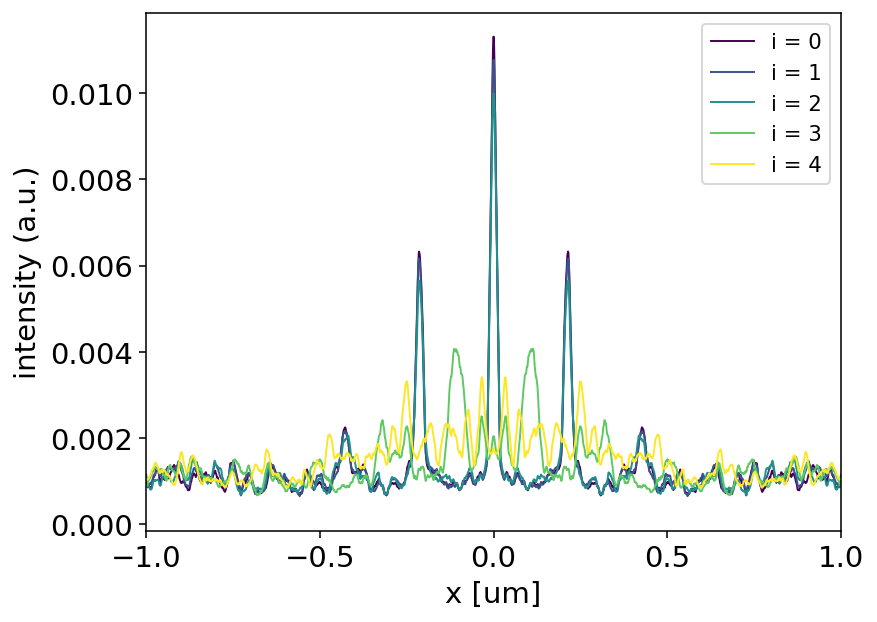

In [13]:
widths = np.array([2**22, 2**23, 2**24])*dicts[0]["sim_params"].dx*1e3
evals = [10, 50, 100, 200]
dxs = [1, 2, 4]
Nwvls = [8, 12, 15]
deltaxs = [16, 32, 64, 128, 256]
thicknesses = [0.5, 1, 5, 10, 20, 50]

for color, i in zip(colors, plot_list):
    sim_params = dicts[i]["sim_params"]
    opt_I = Is[f"arr_{i}"]
    
    plt.plot(
        sim_params.x.cpu() * 1e6, 
        opt_I.reshape(sim_params.Nx),
        color=color, 
        linewidth=1, 
        label=f"i = {i}"
    )

# plt.axvline(dicts[i]["args"][1]*sim_params.dx*1e6, color='red', linestyle='--', linewidth=0.5, label='objective region')
# plt.axvline(-dicts[i]["args"][1]*sim_params.dx*1e6, color='red', linestyle='--', linewidth=0.5,)

plt.xlabel('x [um]')
plt.ylabel('intensity (a.u.)')
plt.xlim([-1, 1])
plt.legend(fontsize=11, loc='upper right')
plt.show()

In [14]:
thickness_dict = {
    "arr": np.array([0.05, 0.1, 0.25, 0.5, 1.0, 2.0]), 
    "string": "thickness [um]"
}

width_dict = {
    "arr": np.array([2**20, 2**21, 2**22])*dicts[0]["sim_params"].dx*1e3, 
    "string": "width [mm]"
}

max_eval_dict = {
    "arr": [10, 20, 50, 100], 
    "string": "max evals"
}

inner_max_eval_dict = {
    "arr": [2, 5, 10, 20, 50], 
    "string": "max inner evals"
}

x_init_zero_width_dict = {
     "arr": [0, 16, 32, 64, 128, 256, 512], 
    "string": "$x_i$ zero width [nm]"
}

center_width_dict = {
    "arr": np.array([8, 16, 32, 256, 1024]), 
    "string": "center width [nm]"
}

Nwvl_dict = {
    "arr": [5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 40, 50], 
    "string": "$N_\\lambda$", 
    "ticks": [10, 20, 30, 40, 50]
}

focal_length_dict = {
    "arr": [0.1, 1, 5, 10, 50, 100], 
    "string": "f [mm]"
}

feature_size_dict = {
    "arr": [4, 8, 16, 32, 64, 128, 256], 
    "string": "$\Delta x$ [nm]"
}

betas_dict = {
    "arr": range(len(dicts)), 
    "string": "beta schedule"
}

filter_comp_dict = {
    "arr": [0, 1], 
    "string": "filter status"
}

method_dict = {
    "arr": [0, 1], 
    "string": "method"
}

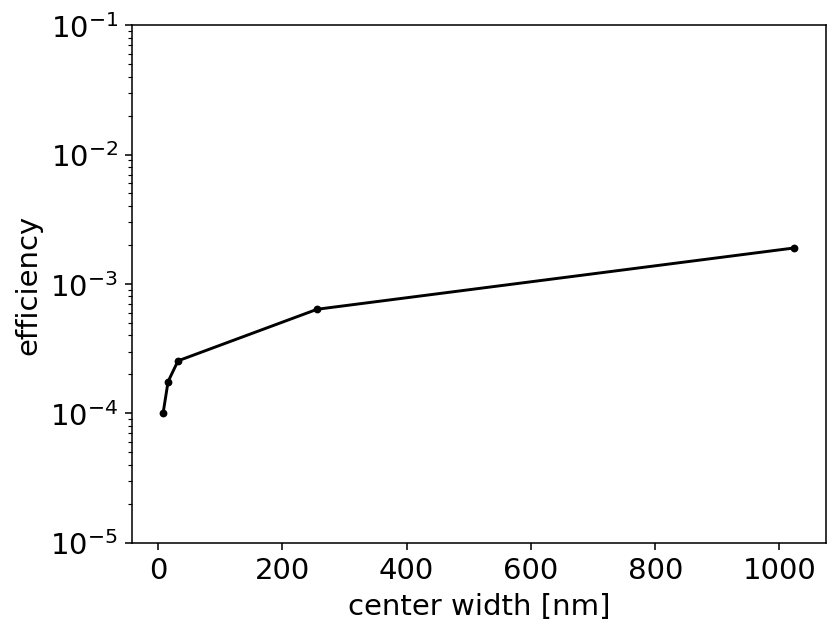

In [15]:
plot_dict = center_width_dict

eff = objs
eff = [objs[i] / dicts[i]["args"][1] for i in range(len(dicts))]
eff = [objs[i] / dicts[i]["sim_params"].Nx for i in range(len(dicts))]
eff = [objs[i] / dicts[i]["P_in"].cpu().numpy() for i in range(len(dicts))]

plt.plot(
    plot_dict["arr"], 
    eff,
    color = "black",
    marker = "."
)
# plt.xticks(plot_dict["ticks"])

# plt.axhline(0.4, color="red")

plt.xlabel(plot_dict["string"])
plt.ylabel('efficiency')
plt.semilogy()
plt.ylim([1e-5, 1e-1])
plt.show()

In [16]:
[eff[i]*1e2 for i in range(len(eff))]

[0.01005947479834184,
 0.017584780656476257,
 0.025426295811340437,
 0.06368615036314045,
 0.18966220673977424]

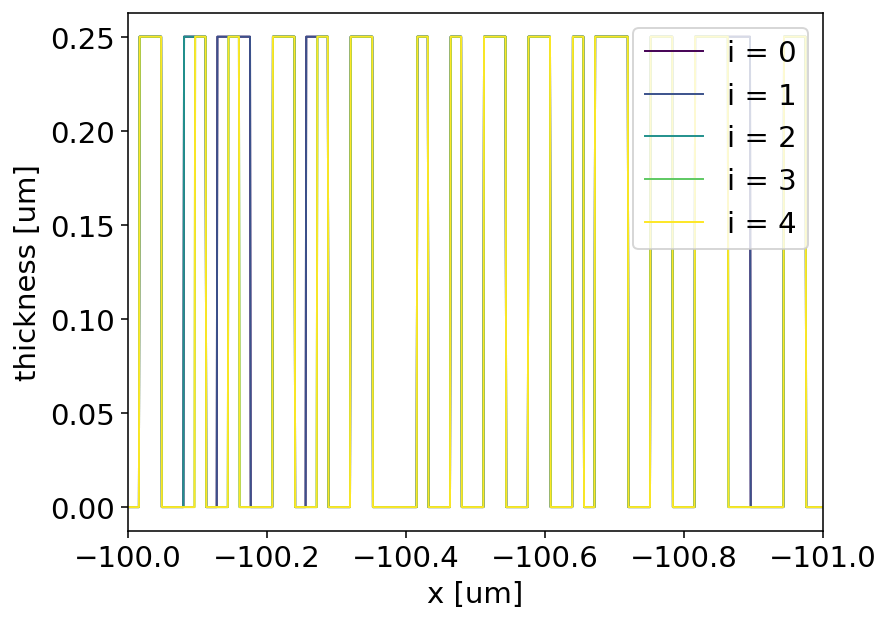

In [249]:
for color, i in zip(colors, plot_list):
    sim_params = dicts[i]["sim_params"]
    opt_x = xs_full[f"arr_{i}"]
    
    plt.plot(
        sim_params.x.cpu() * 1e6, 
        opt_x.reshape(sim_params.Nx) * dicts[i]["elem_params"]["thickness"] * 1e6,
        color=color, 
        linewidth=1, 
        label=f"i = {i}"
    )

plt.xlabel('x [um]')
plt.ylabel('thickness [um]')
plt.xlim([-100, -101])
plt.legend(loc='upper right')
plt.show()

# Source plots

In [181]:
lams = dicts[7]["sim_params"].lams.cpu()
weights = dicts[7]["sim_params"].weights.cpu()

h = 4.135667696e-15 # eV s
c = 299792458 # m/s
energies = h * c / lams

In [184]:
weights.shape

torch.Size([15])

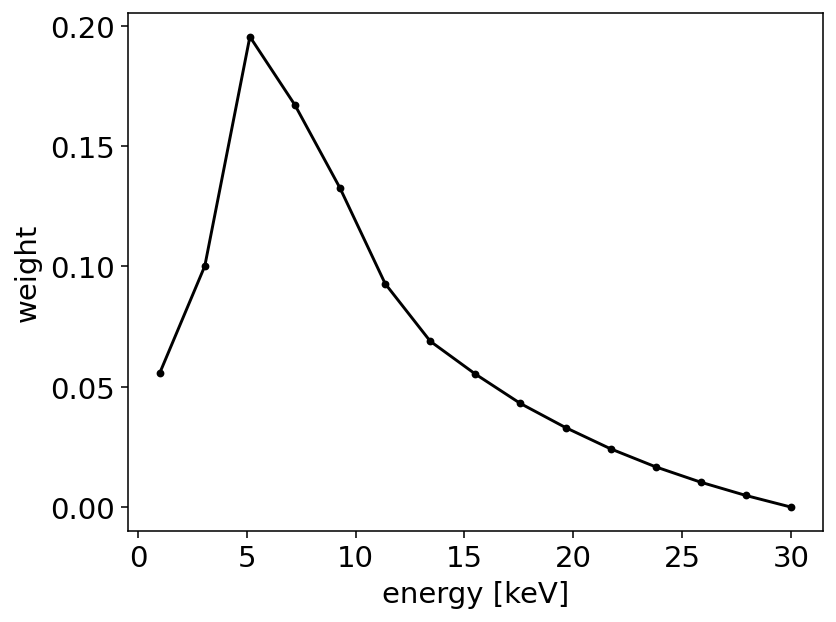

In [185]:
plt.plot(energies/1e3, weights, color="black", marker=".")
plt.xlabel("energy [keV]")
plt.ylabel("weight")
plt.show()

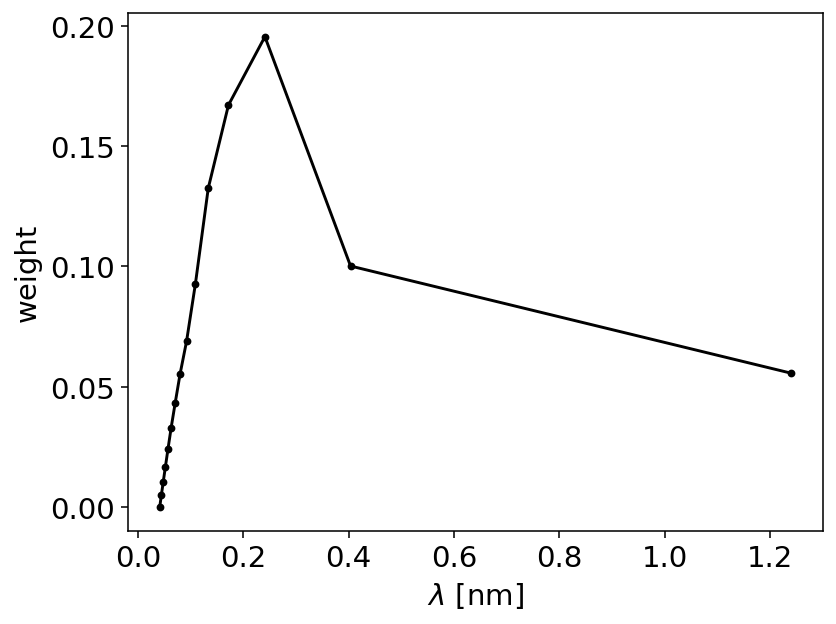

In [186]:
plt.plot(lams*1e9, weights, color="black", marker=".")
plt.xlabel("$\\lambda$ [nm]")
plt.ylabel("weight")
plt.show()

In [84]:
n_lams = refractive_index_at_wvl(lams, dicts[0]["elem_params"]["elem_map"]).cpu().numpy()
k_lams = np.imag(n_lams)
abs_coeffs = 4*np.pi * k_lams / lams * 1e-6
abs_props = 1 - np.exp(-abs_coeffs)

/state/partition1/slurm_tmp/2072487.0.0/ipykernel_2229690/2070796615.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  abs_props = 1 - np.exp(-abs_coeffs)


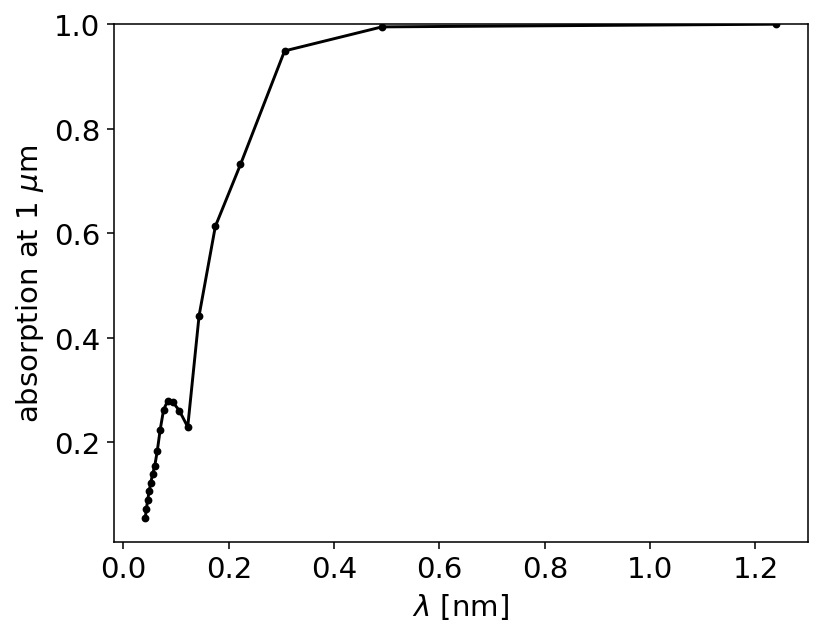

In [85]:
plt.plot(lams*1e9, abs_props, color="black", marker=".")
plt.xlabel("$\\lambda$ [nm]")
plt.ylabel("absorption at 1 $\mu$m")
# plt.semilogy()
plt.ylim([0.01, 1])
# plt.xlim([0, 0.25])
plt.show()